## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import requests
import zipfile

url = 'https://drive.upm.es/s/2DDPE2zHw5dbM3G/download'
zip_name = 'dataset.zip'

r = requests.get(url, stream=True)
with open(zip_name, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        f.write(chunk)

if os.path.getsize(zip_name) < 10000:
    print(f"ERREUR : Le fichier {zip_name} est trop petit. Le lien est invalide ou nécessite une connexion.")
else:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(".") 

    target_file = 'xview_ann_train.json'
    found_path = None
    
    for root, dirs, files in os.walk("."):
        if target_file in files:
            found_path = os.path.join(root, target_file)
            break
    
    if found_path:
        print(f"SUCCÈS : Fichier trouvé à : {found_path}")
        
        import json
        json_file = found_path 
        
        with open(json_file) as ifs:
            json_data = json.load(ifs)
        print("Base de données chargée avec succès !")
        
    else:
        print(f"ERREUR : {target_file} reste introuvable après extraction.")

SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2026-02-13 10:46:31.073927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770979591.243754      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770979591.293093      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770979591.686836      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770979591.686880      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770979591.686883      55 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 56.1 MB/s eta 0:00:00:00:0100:01


In [6]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [10]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, AveragePooling2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.activations import swish
import tensorflow as tf

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
# Réduit le bruit et le nombre de paramètres drastiquement
model.add(MaxPooling2D(pool_size=(4, 4))) 
model.add(Flatten())

# Layer 1
model.add(Dense(512, kernel_initializer='lecun_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish')) 
#model.add(Dropout(0.4)) 

# Layer 2
model.add(Dense(256, kernel_initializer='lecun_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish'))
#model.add(Dropout(0.4))

# Layer 3
model.add(Dense(128, kernel_initializer='lecun_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish'))
#model.add(Dropout(0.4))

# Output
model.add(Dense(len(categories)))
model.add(Activation('softmax'))

# Learning rate légèrement plus bas car SELU est très dynamique
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0005, 
    decay_steps=40 * (len(anns_train) // 32)
)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
    # Gamma plus fort pour récupérer les "Fishing Vessels" la ou recall plus bas 
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=3.0), 
    metrics=['accuracy']
)
model.summary()

I0000 00:00:1770979610.953939      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,817,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,983,309 (19.01 MB)

 Trainable params: 4,983,309 (19.01 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#from tensorflow.keras.optimizers import Adam
#
## Learning rate is changed to 0.001
#opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
#reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, early_stop, terminate]

In [13]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # regularization
                img = img.astype(np.float32) / 255.0
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32 # change to 32 to stabilize the gradients
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [15]:
import math
import numpy as np

print('Training model')
epochs = 42 # model still improving after 20 epochs -> stabilization
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/42


I0000 00:00:1770979614.049895     207 service.cc:152] XLA service 0x79853800ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770979614.049932     207 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770979614.425567     207 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/528 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.1007 - loss: 0.5193

I0000 00:00:1770979615.551952     207 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3165 - loss: 0.3449
Epoch 1: val_accuracy improved from -inf to 0.42667, saving model to model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 61s 111ms/step - accuracy: 0.3166 - loss: 0.3448 - val_accuracy: 0.4267 - val_loss: 0.2496
Epoch 2/42
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4351 - loss: 0.2445
Epoch 2: val_accuracy improved from 0.42667 to 0.44160, saving model to model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 55s 105ms/step - accuracy: 0.4352 - loss: 0.2445 - val_accuracy: 0.4416 - val_loss: 0.2480
Epoch 3/42
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4672 - loss: 0.2189
Epoch 3: val_accuracy improved from 0.44160 to 0.47733, saving model to model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 55s 104ms/step - accuracy: 0.4673 - loss: 0.2189 - val_accuracy: 0.4773 - val_loss: 0.2166
Epoch 4/42
527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4939 - loss: 0.2002
Epoch 4: val_accuracy improved from 0.47733 to 0.48480

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [17]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

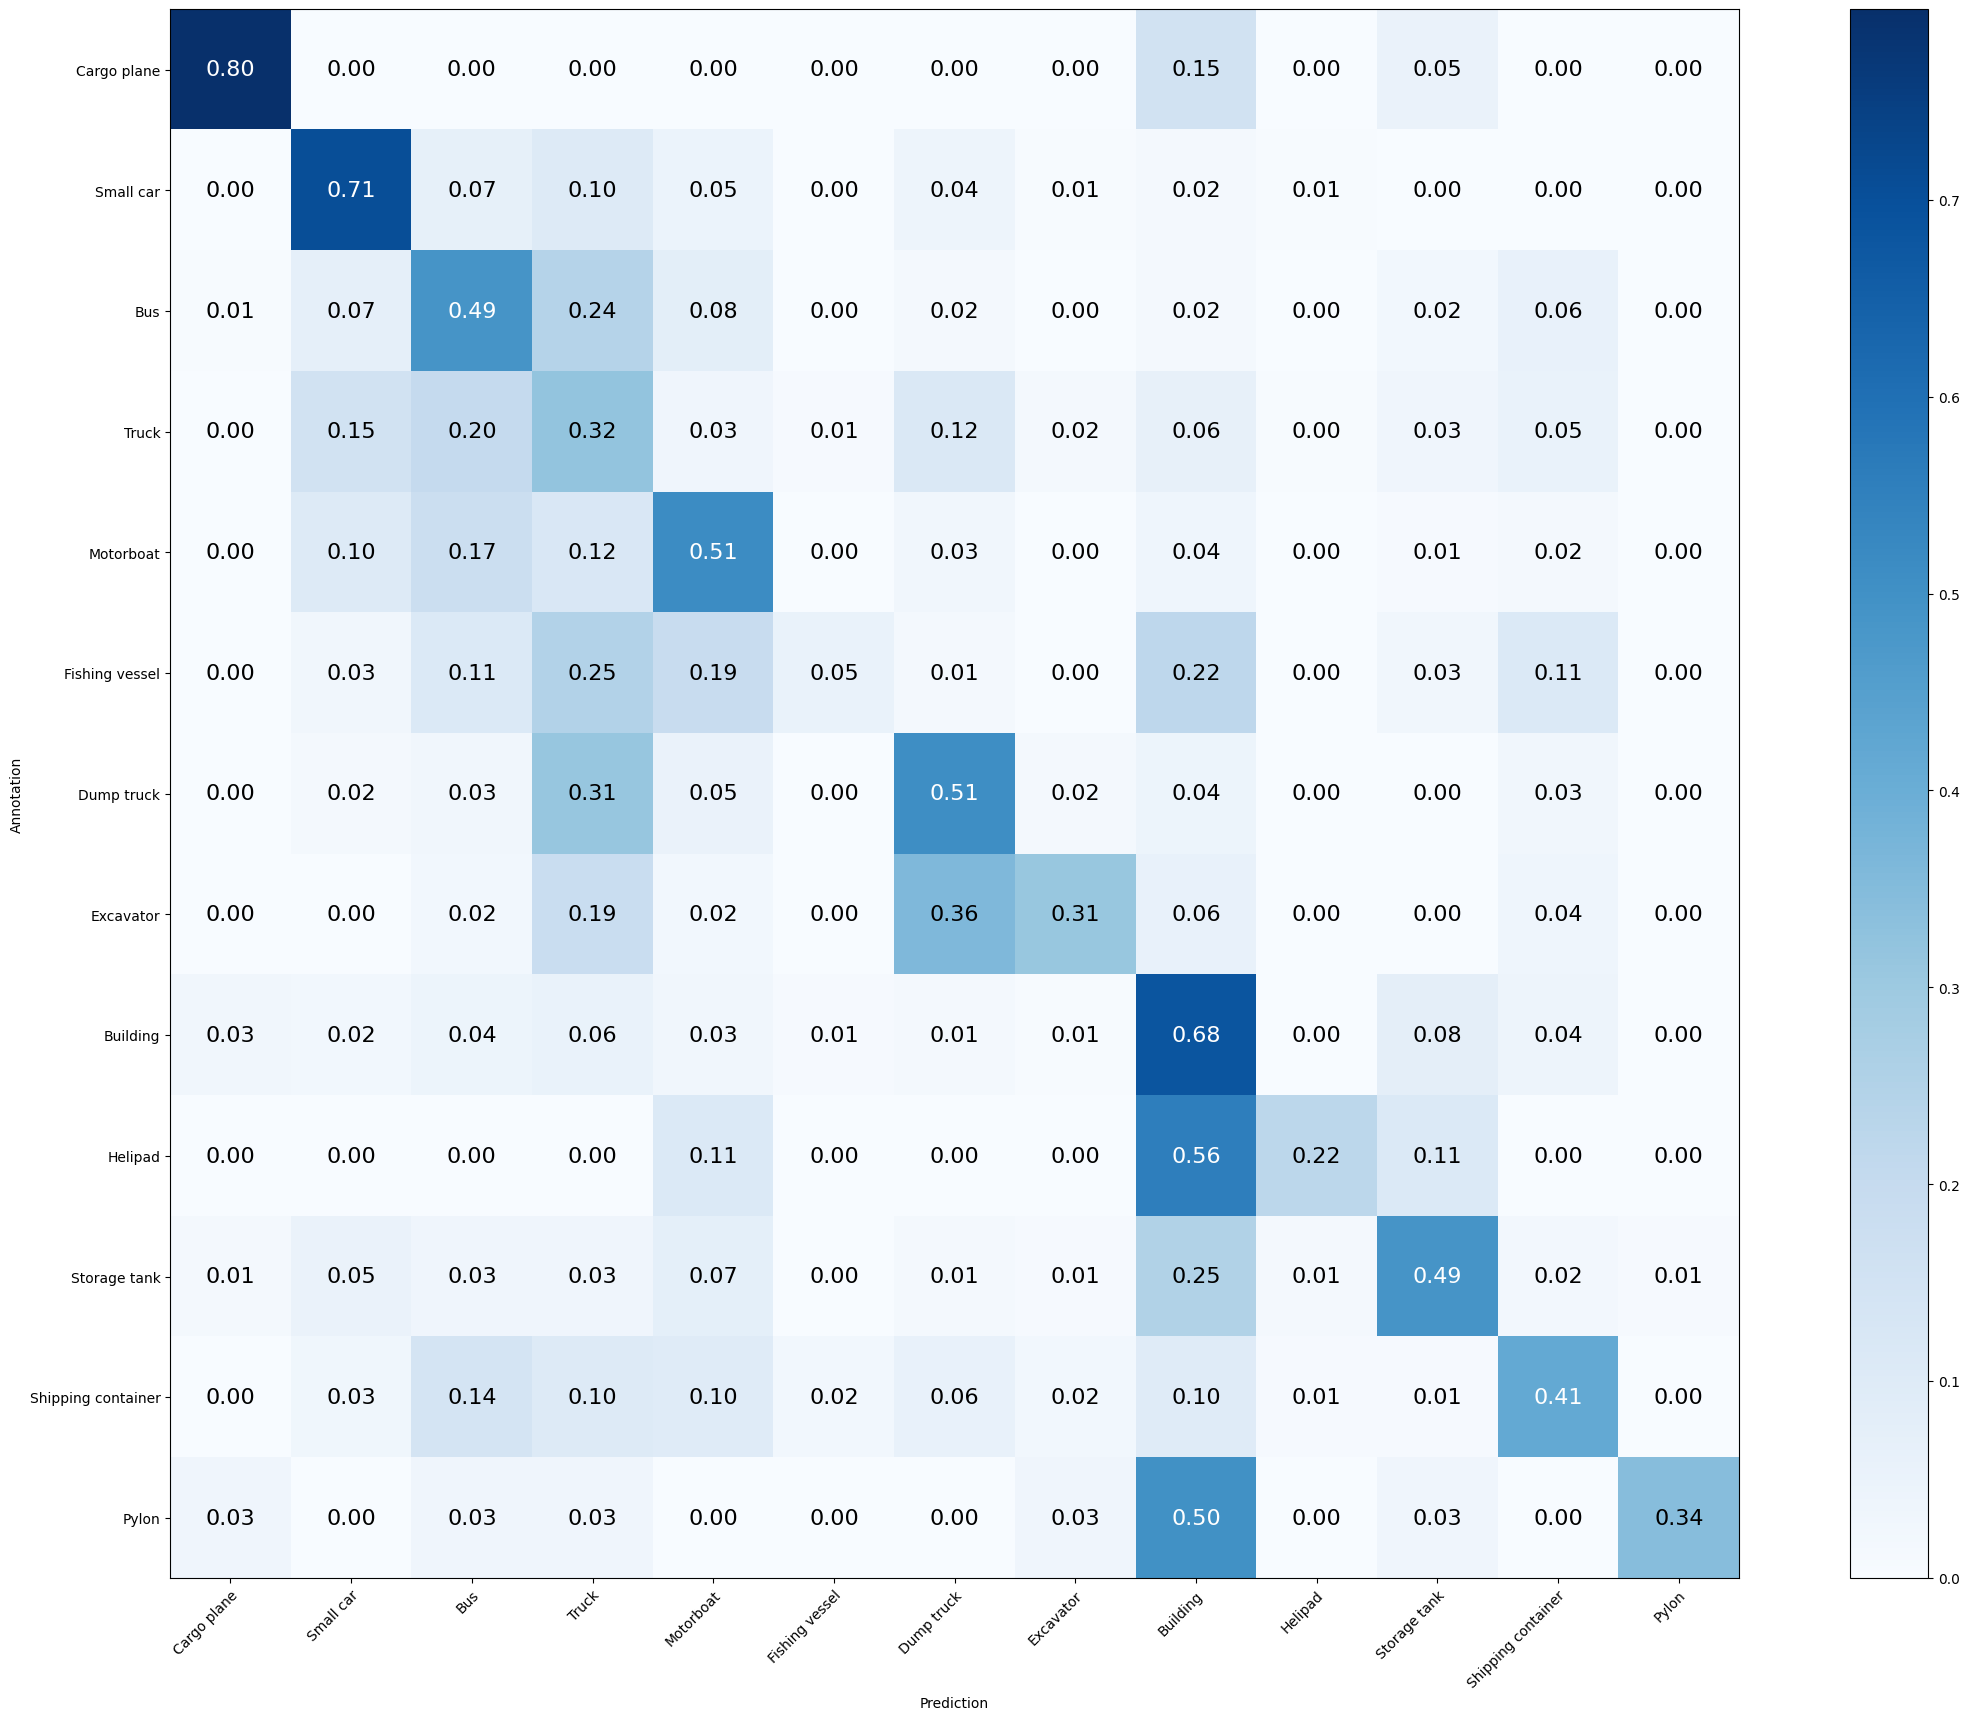

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 52.107%
Mean Recall: 44.971%
Mean Precision: 52.036%
> Cargo plane: Recall: 79.661% Precision: 77.049% Specificity: 99.229% Dice: 78.333%
> Small car: Recall: 70.517% Precision: 73.418% Specificity: 94.567% Dice: 71.938%
> Bus: Recall: 48.851% Precision: 37.445% Specificity: 91.652% Dice: 42.394%
> Truck: Recall: 31.950% Precision: 27.899% Specificity: 87.821% Dice: 29.787%
> Motorboat: Recall: 51.376% Precision: 37.086% Specificity: 94.621% Dice: 43.077%
> Fishing vessel: Recall: 5.479% Precision: 30.769% Specificity: 99.501% Dice: 9.302%
> Dump truck: Recall: 50.847% Precision: 39.474% Specificity: 94.764% Dice: 44.444%
> Excavator: Recall: 30.864% Precision: 62.500% Specificity: 99.164% Dice: 41.322%
> Building: Recall: 68.320% Precision: 64.921% Specificity: 91.138% Dice: 66.577%
> Helipad: Recall: 22.222% Precision: 25.000% Specificity: 99.678% Dice: 23.529%
> Storage tank: Recall: 48.684% Precision: 59.677% Specificity: 97.098% Dice: 53.623%
> Shipping container: R

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
root_dir = './xview_recognition/'
test_dir = os.path.join(root_dir, 'xview_test')
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for filename in filenames:
        rel_dir = os.path.relpath(dirpath, root_dir)
        clean_filename = os.path.join(rel_dir, filename)
        image = GenericImage(clean_filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [21]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [1]:
import json
with open('prediction.json', 'w') as f:
    json.dump(predictions_data, f)

NameError: name 'predictions_data' is not defined